## Import Library

In [ ]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [ ]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

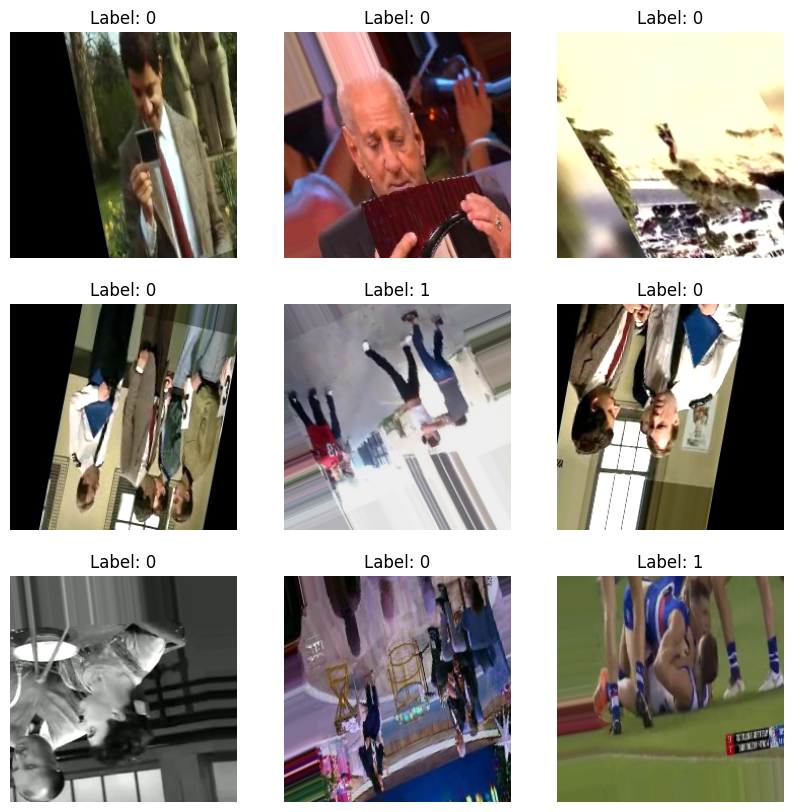

In [ ]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [ ]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# All Freeze
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_AllFreeze_0.001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.6405 - loss: 1.2587
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 671ms/step - accuracy: 0.6413 - loss: 1.2561 - val_accuracy: 0.5000 - val_loss: 1.0495
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7522 - loss: 0.8781
Epoch 2: val_accuracy improved from 0.50000 to 0.52273, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 626ms/step - accuracy: 0.7522 - loss: 0.8778 - val_accuracy: 0.5227 - val_loss: 0.9490
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.7539 - loss: 0.8469
Epoch 3: val_accuracy improved from 0.52273 to 0.66136, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 615ms/step - accuracy: 0.7542 - loss: 0.8463 - val_accuracy: 0.6614 - val_loss: 0.8392
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8210 - loss: 0.7003
Epoch 4: val_accuracy did not improve from 0.66136
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - accuracy: 0.8207 - loss: 0.7008 - val_accuracy: 0.6068 - val_loss: 0.8548
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.7953 - loss: 0.7396
Epoch 5: val_accuracy improved from 0.66136 to 0.72273, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 608ms/step - accuracy: 0.7955 - loss: 0.7394 - val_accuracy: 0.7227 - val_loss: 0.7908
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8122 - loss: 0.6920
Epoch 6: val_accuracy did not improve from 0.72273
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 614ms/step - accuracy: 0.8123 - loss: 0.6919 - val_accuracy: 0.7068 - val_loss: 0.8374
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8263 - loss: 0.6509
Epoch 7: val_accuracy improved from 0.72273 to 0.85000, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 613ms/step - accuracy: 0.8260 - loss: 0.6515 - val_accuracy: 0.8500 - val_loss: 0.6150
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8145 - loss: 0.6496
Epoch 8: val_accuracy did not improve from 0.85000
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 610ms/step - accuracy: 0.8146 - loss: 0.6496 - val_accuracy: 0.8318 - val_loss: 0.6119
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8023 - loss: 0.6546
Epoch 9: val_accuracy did not improve from 0.85000
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.8025 - loss: 0.6540 - val_accuracy: 0.8295 - val_loss: 0.6049
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8389 - loss: 0.5799
Epoch 10: val_accuracy improved from 0.85000 to 0.86818, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 614ms/step - accuracy: 0.8389 - loss: 0.5800 - val_accuracy: 0.8682 - val_loss: 0.5292
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8473 - loss: 0.5783
Epoch 11: val_accuracy did not improve from 0.86818
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 614ms/step - accuracy: 0.8470 - loss: 0.5790 - val_accuracy: 0.8455 - val_loss: 0.5829
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.8466 - loss: 0.5986
Epoch 12: val_accuracy did not improve from 0.86818
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 607ms/step - accuracy: 0.8463 - loss: 0.5987 - val_accuracy: 0.8614 - val_loss: 0.5256
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8326 - loss: 0.5898
Epoch 13: val_accuracy did not improve from 0.86818
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 604ms/step - accuracy: 0.8324 - loss: 0.5901 - val_accuracy: 0.8545 - val_loss: 0.5531
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8266 - loss: 0.5871
Epoch 14: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 615ms/step - accuracy: 0.8502 - loss: 0.5643 - val_accuracy: 0.8727 - val_loss: 0.5051
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8359 - loss: 0.5568
Epoch 17: val_accuracy did not improve from 0.87273
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.8359 - loss: 0.5567 - val_accuracy: 0.8455 - val_loss: 0.5136
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8684 - loss: 0.5166
Epoch 18: val_accuracy improved from 0.87273 to 0.87727, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 615ms/step - accuracy: 0.8681 - loss: 0.5170 - val_accuracy: 0.8773 - val_loss: 0.4561
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8282 - loss: 0.5730
Epoch 19: val_accuracy improved from 0.87727 to 0.88636, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 628ms/step - accuracy: 0.8284 - loss: 0.5727 - val_accuracy: 0.8864 - val_loss: 0.4264
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8416 - loss: 0.5220
Epoch 20: val_accuracy did not improve from 0.88636
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 609ms/step - accuracy: 0.8417 - loss: 0.5219 - val_accuracy: 0.8864 - val_loss: 0.4483
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8369 - loss: 0.5409
Epoch 21: val_accuracy improved from 0.88636 to 0.88864, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 617ms/step - accuracy: 0.8368 - loss: 0.5409 - val_accuracy: 0.8886 - val_loss: 0.4444
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8392 - loss: 0.5376
Epoch 22: val_accuracy improved from 0.88864 to 0.89318, saving model to NoMCLAHE_AllFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - accuracy: 0.8396 - loss: 0.5373 - val_accuracy: 0.8932 - val_loss: 0.4163
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8341 - loss: 0.5202
Epoch 23: val_accuracy did not improve from 0.89318
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.8345 - loss: 0.5199 - val_accuracy: 0.8795 - val_loss: 0.4434
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8812 - loss: 0.4553
Epoch 24: val_accuracy did not improve from 0.89318
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 607ms/step - accuracy: 0.8808 - loss: 0.4557 - val_accuracy: 0.8886 - val_loss: 0.4121
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8695 - loss: 0.4742
Epoch 25: val_accuracy did not improve from 0.89318
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 608ms/step - accuracy: 0.8692 - loss: 0.4747 - val_accuracy: 0.8909 - val_loss: 0.4119
Epoch 26/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8616 - loss: 0.4935
Epoch 26: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 612ms/step - accuracy: 0.8552 - loss: 0.4946 - val_accuracy: 0.9045 - val_loss: 0.3983
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8620 - loss: 0.4835
Epoch 30: val_accuracy did not improve from 0.90455
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.8619 - loss: 0.4836 - val_accuracy: 0.8886 - val_loss: 0.3968
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8316 - loss: 0.5388
Epoch 31: val_accuracy did not improve from 0.90455
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 615ms/step - accuracy: 0.8318 - loss: 0.5382 - val_accuracy: 0.8864 - val_loss: 0.4274
Epoch 32/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8629 - loss: 0.4920
Epoch 32: val_accuracy did not improve from 0.90455
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.8630 - loss: 0.4921 - val_accuracy: 0.8955 - val_loss: 0.3918
Epoch 33/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8627 - loss: 0.4658
Epoch 33: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 618ms/step - accuracy: 0.8695 - loss: 0.4633 - val_accuracy: 0.9091 - val_loss: 0.3682
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8728 - loss: 0.4380
Epoch 38: val_accuracy did not improve from 0.90909
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 607ms/step - accuracy: 0.8728 - loss: 0.4382 - val_accuracy: 0.9045 - val_loss: 0.3868
Epoch 39/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8833 - loss: 0.4453
Epoch 39: val_accuracy did not improve from 0.90909
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.8828 - loss: 0.4457 - val_accuracy: 0.8909 - val_loss: 0.3823
Epoch 40/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8481 - loss: 0.4589
Epoch 40: val_accuracy did not improve from 0.90909
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 606ms/step - accuracy: 0.8484 - loss: 0.4586 - val_accuracy: 0.8955 - val_loss: 0.3720
Epoch 41/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8702 - loss: 0.4442
Epoch 41: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9018 - loss: 0.3875
Validation Loss: 0.4468137323856354
Validation Accuracy: 0.8727272748947144


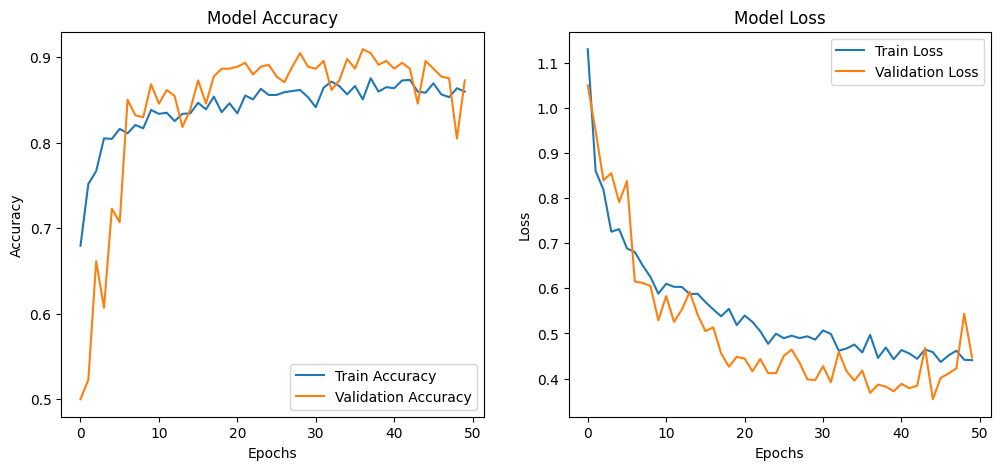

In [ ]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [ ]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_AllFreeze_0.001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8667 - loss: 0.4213
Test Accuracy : 90.99%
Test Loss     : 0.365


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step


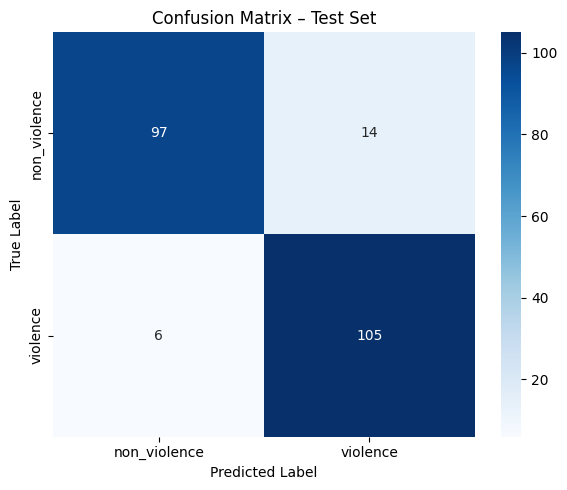


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.94      0.87      0.91       111
    violence       0.88      0.95      0.91       111

    accuracy                           0.91       222
   macro avg       0.91      0.91      0.91       222
weighted avg       0.91      0.91      0.91       222



In [ ]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))